<a id="top"></a>
# Getting Started with the Iguazio Data Science Platform

## Overview <a id="gs-overview"></a>

This tutorial is designed to demonstrate some of the main capabilities of the Iguazio Data Science Platform (**"the platform"**).
The tutorial walks you through a basic machine-learning (ML) workflow, which includes the following steps; before running the steps, ensure that the required [prerequisites](#gs-prerequisites) are met:

1. [Create and configure a new project](#gs-step-project-create-n-config)
2. [Ingest a data set](#gs-step-ingest-data)
3. [Explore the data](#gs-step-explore-data)
4. [Run model training at scale](#gs-step-run-model-training)
5. [Test your model](#gs-step-test-model)
6. [Create and run a fully automated ML pipeline](#gs-step-create-n-run-ml-pipeline)

By the end of this tutorial you will learn how to

1. Create a new platform project.
2. Create functions and track experiments while running them.
3. Store artifacts to be used and managed in a central database.
4. Leverage the MLRun functions marketplace.
5. Create an automated ML pipeline.
6. Run your code on a distributed Kubernetes cluster without any DevOps overhead.
7. Create a scalable endpoint for model serving.

The tutorial uses the [Iris flower data set](http://archive.ics.uci.edu/ml/datasets/iris) &mdash; a popular data set that is widely used for basic data science tutorials.
The data set contains a set of 150 records under five attributes &mdash; petal length, petal width, sepal length, sepal width, and species. Your model will classify the species based on the other four attributes.

## Prerequisites <a id="gs-prerequisites"></a>

<a id="gs-mlrun-install"></a>The tutorial uses MLRun to create a project, implement and execute an ML pipeline, and track the execution.
(For more information about MLRun, see Step 1.)
To use MLRun, you must first ensure that it's installed and running as a service on your platform cluster.
Look for an `mlrun` service on the **Services** page of the platform dashboard.
For more information and additional assistance, contact the Iguazio [support team](mailto:support@iguazio.com).

To use MLRun from Jupyter Notebook, you need to run the following code to install the `mlrun` Python package.
This needs to be done only once per Jupyter Notebook service.
> **Note:** You must **restart the Jupyter kernel** to complete the installation.

In [ ]:
!python -m pip install mlrun

## Step 1: Create and Configure a New Project <a id="gs-step-project-create-n-config"></a>

Start out by creating a new platform project and making some initial configurations.

### Create a New Project <a id="gs-create-project"></a>

Projects in the platform are used to package multiple functions, workflows, and artifacts.
Projects are created by using the `new_project` MLRun method, which receives the following parameters:

- **`name`** (Required) &mdash; the project name.
- **`context`** &mdash; the path to a local project directory (the project's context directory).
  The project directory contains a project-configuration file (default: **project.yaml**), which defines the project, and additional generated Python code.
  The project file is created when you save your project (using the `save` MLRun project method), as demonstrated in Step 6.
- **`functions`** &mdash; a list of functions objects or links to function code or objects.
- **`init_git`** &mdash; set to `True` to perform Git initialization of the project directory (`context`).
  > **Note:** It's customary to store project code and definitions in a Git repository.

Projects are visible in the MLRun dashboard only after they're saved to the MLRun database, which happens whenever you run code for a project.

The following code creates a project named "getting-started-iris-&lt;V3IO_USERNAME&gt;", where **&lt;V3IO_USERNAME&gt;** is your current running username in the platform, and sets the project directory to a **conf** directory in the current tutorial directory (**/User/getting-started-tutorial/conf**).

> **Note:** Platform projects are shared among all users of the parent tenant, to facilitate collaboration. Therefore,
>
> - Synchronize your projects execution with other users on your platform cluster, as needed, or use unique project names to avoid conflicts.
>   You can easily change the default project name for this tutorial by changing the definition of the `project_name` variable in the following code.
> - Don't include in your project proprietary information that you don't want to expose to other users.
>   Note that while projects are a useful tool, you can easily develop and run code in the platform without using projects.

In [1]:
from os import path, getenv
from mlrun import new_project

project_name = '-'.join(filter(None, ['getting-started-iris', getenv('V3IO_USERNAME', None)]))
project_path = path.abspath('conf')
project = new_project(project_name, project_path, init_git=True)

print(f'Project path: {project_path}\nProject name: {project_name}')

Project path: /User/getting-started-tutorial/conf
Project name: getting-started-iris-iguazio


### Configure MLRun <a id="gs-mlrun-config"></a>

[MLRun](https://github.com/mlrun/mlrun) is a generic and convenient mechanism for data scientists and software developers to describe and run tasks related to machine learning in various, scalable runtime environments and ML pipelines while automatically tracking executed code, metadata, inputs, and outputs.
MLRun integrates with the Nuclio serverless framework and with the Kubeflow Pipelines framework for running ML pipelines.
The tutorial uses MLRun to create a project, implement and execute an ML pipeline, and track the execution.
Before running your code, you need to set some MLRun configurations:

- <a id="gs-mlrun-config-artifcats-path"></a>**Artifacts path** &mdash; the location for storing versioned data artifacts (such as files, objects, data sets, and models) that are produced or consumed by functions, runs, and workflows.
  The path can be defined either as a local directory path or as a URL (of the format `s3://*`, `v3io://*`, etc.).
  You can set the artifacts path either by defining an `MLRUN_ARTIFACT_PATH` environment variable (which applies globally throughout the current environment) or as part of the MLRun configuration.
 
  If the target directory doesn't exist, MLRun creates it.
  You can use the notation `{{run.uid}}` in the path to signify the current run ID.
  For pipelines, you can use the notation `{{workflow.uid}}` to signify the workflow ID.
  This allows you to create a unique artifacts directory for each executed job or workflow.

  After you run an MLRun job, the artifacts directory might contain one or more of the following directories:
 
  - **plots** &mdash; a directory for storing images, figures, and plotlines.
  - **models** &mdash; a directory for storing all trained models.
  - **data** &mdash; a directory for storing any other type of data artifact, such as data sets.


- <a id="gs-mlrun-config-mlrun-db-path"></a>**The MLRun DB path** &mdash; the path to an MLRun database (DB) directory or the URL of an MLRun API service.
  The MLRun service initializes `mlconf.dbpath` to the default API URL for the current environment (usually `http://mlrun-api:8080`).

The following code sets the artifacts path to a **jobs** directory within the tutorial directory (**/User/getting-started-tutorial/jobs**), and the MLRun DB path to the currently configured MLRun DB path, if exists, or to `http://mlrun-api:8080` otherwise.
(In Step 6 of the tutorial, you'll create a full pipeline and store the pipeline artifacts in a **pipeline** tutorial directory.)

In [2]:
from mlrun import run_local, NewTask, mlconf, import_function, mount_v3io

# Target location for storing pipeline artifacts
artifact_path = path.abspath('jobs')
# MLRun DB path or API service URL
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

print(f'Artifacts path: {artifact_path}\nMLRun DB path: {mlconf.dbpath}')

Artifacts path: /User/getting-started-tutorial/jobs
MLRun DB path: http://mlrun-api:8080


### Import and Configure Nuclio <a id="gs-nuclio-import-n-config"></a>


[Nuclio](https://nuclio.io/) is a high-performance open-source and managed serverless framework, which is available as a predefined tenant-wide platform service (`nuclio`).
The tutorial uses Nuclio to create and deploy serverless functions.
Therefore, you need to import the Nuclio package and configure Nuclio for your project.

The platform's Jupyter Notebook service preinstalls the [nuclio-jupyter SDK](https://github.com/nuclio/nuclio-jupyter/blob/master/README.md) for creating and deploying Nuclio functions with Python and Jupyter Notebook.
The tutorial uses the Nuclio magic commands and annotation comments of this SDK to automate function code generation.
The magic commands are initialized when you import the `nuclio` package.<br>
The `%nuclio` magic commands are used to run Nuclio commands from Jupyter notebooks (`%nuclio <Nuclio command>`).
You can also use `%%nuclio` at the start of a cell to identify the entire cell as containing Nuclio code.
The magic commands are initialized when you import the `nuclio` package.<br>
The `# nuclio: start-code`, `# nuclio: end-code`, and `# nuclio: ignore` section-marker annotations notify Nuclio of the beginning or end of code sections.
Nuclio ignores all notebook code before a `# nuclio: start-code` marker or after an `# nuclio: end-code` marker.
Nuclio translates all other notebook code sections into function code, except for sections that are marked with the `# nuclio: ignore` marker.

#### Import Nuclio <a id="gs-nuclio-import"></a>


The following code imports the `nuclio` Python package.

In [3]:
import nuclio

#### Configure Nuclio <a id="gs-nuclio-config"></a>


The following code uses the `# nuclio: start-code` marker to instruct Nuclio to start processing code only from this location, and then performs basic Nuclio function configuration &mdash; defining the name of the function's container image (`mlrun/ml-models`) and the function type (`job`).

> **Note:** You can add code to define function dependencies and perform additional configuration after the `# nuclio: start-code` marker.

In [4]:
# nuclio: start-code

In [5]:
%nuclio config spec.image = "mlrun/ml-models"
%nuclio config kind = "job"

%nuclio: setting spec.image to 'mlrun/ml-models'
%nuclio: setting kind to 'job'


## Step 2: Ingest a Data Set <a id="gs-step-ingest-data"></a>


Define and run a Python function that downloads the Iris flower data set from Amazon Web Services (AWS) S3 bucket to the platform's local NoSQL data store, and stores it as an MLRun data set.

### Initialization <a id="gs-step-ingest-data-init"></a>


Define the source URL for downloading the data set.

> **Note:** As explained earlier, the `nuclio: ignore` annotation is used to instruct Nuclio to ignore this cell. 

In [6]:
# nuclio: ignore
# Set the source-data URL
source_url = 'http://iguazio-sample-data.s3.amazonaws.com/iris_dataset.csv'

### Define a Data-Ingestion Function <a id="gs-step-ingest-data-define-function"></a>


Define a data-ingestion function that downloads the configured data set from an AWS S3 bucket and saves it to the platform's local NoSQL data store.

In [7]:
from os import path
import pandas as pd


# Ingest a data set into the platform
def get_data(context, source_url, format='csv'):

    iris_dataset = source_url.as_df()

    target_path = path.join(context.artifact_path, 'data')
    # Optionally print data to your logger
    context.logger.info('Saving Iris data set to {} ...'.format(target_path))

    # Store the data set in your artifacts database
    context.log_dataset('iris_dataset', df=iris_dataset, format=format,
                        index=False, artifact_path=target_path)

The following cell uses the `# nuclio: end-code` marker to mark the end of a Nuclio code section and instruct Nuclio to stop parsing the notebook at this point.<br>
> **IMPORTANT:** Do not remove the end-code cell.

In [8]:
# nuclio: end-code

<a id='gs-run-ingest-func'></a>
### Run the Data-Ingestion Function

MLRun enables you to run function code either locally in your preferred development environment (IDE) or web notebook (in this case, Jupyter Notebook), or on a large cluster (in this case, the platform's distributed Kubernetes cluster).

For either execution method, you can specify function parameters, inputs, and outputs either by passing them as parameters to the run method (as done in this tutorial) or by configuring them in a task object that is then passed to the run method; (for more information about tasks, see Step 4 of this tutorial).
In each run, you can specify new function inputs, parameters/hyperparameters, etc.
For more information, see the [**mlrun_basics**](https://github.com/mlrun/mlrun/blob/master/examples/mlrun_basics.ipynb) example notebook.

After the code execution completes, review the output, as demonstrated in the next sections.

<a id='gs-run-ingest-func-local'></a>
#### Run the Function Locally in Jupyter Notebook

Start out by running your function locally from within Jupyter Notebook.
This is done by using the MLRun `run_local` method.

When using this method, the function's inputs and outputs are automatically recorded and stored in the MLRun experiment and data-tracking database (**"the MLRun DB"**).

In [9]:
# Run the data-ingestion function locally in Jupyter Notebook
get_data_run = run_local(name='get_data',
                         handler=get_data,
                         inputs={'source_url': source_url},
                         project=project_name, artifact_path=artifact_path)

[mlrun] 2020-06-25 13:31:45,647 starting run get_data uid=240f67b74aeb477fa52e1fc8285d8af5  -> http://mlrun-api:8080
[mlrun] 2020-06-25 13:31:45,995 Saving Iris data set to /User/getting-started-tutorial/jobs/data ...



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iris-iguazio,...285d8af5,0,Jun 25 13:31:45,completed,get_data,v3io_user=iguaziokind=handlerowner=iguaziohost=iguazio-jupyter-5bcf4bffc8-fl94k,source_url,,,iris_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run 240f67b74aeb477fa52e1fc8285d8af5 --project getting-started-iris-iguazio , !mlrun logs 240f67b74aeb477fa52e1fc8285d8af5 --project getting-started-iris-iguazio
[mlrun] 2020-06-25 13:31:46,355 run executed, status=completed


### Review the Run Output <a id="gs-ingest-func-output-review"></a>


The output cell for your function execution contains a table with run information &mdash; including the state of the execution, all inputs and parameters, and the execution results and artifacts.
Click on the `iris_dataset` artifact in the **artifacts** column to see a short summary of the data set, as illustrated in the following image:
<br><br>
![getting_started-get_data-details](./assets/getting_started-get_data-details.png)

MLRun features a graphical user interface (**"the MLRun dashboard"**), which displays detailed information about executed jobs, artifacts, and functions &mdash; including job states, inputs, parameters, artifacts, execution results, and logs.
This dashboard also allows you to filter the display based on different criteria.<br>
To open the dashboard, simply select the MLRun service link (`mlrun`) from the **Services** page of the platform dashboard.

On the MLRun dashboard's **Projects** home page, select the **Jobs** link for the current project ("getting-started-iris") to open a **Jobs** page with a **Monitor** tab that displays information about the project's executed jobs:
<br><br>
<img src="./assets/getting_started-ui-jobs-monitor.png" alt="ui-jobs-monitor" width="800"/>

Select the `get_data` function to see detailed information about the function and its execution &mdash; including the execution start time and status, metadata, inputs, artifacts, run results, and logs:
<br><br>
<img src="./assets/getting_started-get_data-ui-jobs.png" alt="get-iris-data-ui-jobs" width="800"/>

Return to the dashboard's **Projects** home page and select the **Artifacts** link for the current project to open an **Artifacts** page with a **Monitor** tab that displays information about your project's artifacts.
Select the "get_data_iris_dataset" artifact to view information about the "iris_dataset" artifact of the `get_data` function (**iris_dataset.csv**); note that you can also preview the data set and see related metadata:
<br><br>
<img src="./assets/getting_started-get_data-ui-artifacts.png" alt="get-iris-data-ui-artifacts" width="800"/>

> **Note:** There are also other ways that you can view run artifacts, in addition to the notebook run-output table and the MLRun dashboard:
> - In your notebook, use Python print or display methods, such as `IPython.display`, to display the artifact of a run object, as demonstrated later in this tutorial.
> - On the platform dashboard, select **Data** from the side navigation menu, and then select your data container from the **Browse** tab; the tutorial stores data in the "users" container.
>   Then, navigate to your project's artifacts directory, locate the artifact file, and double-click it to view it in the browse table.<br>
>   You can also download platform data files from the dashboard to your local environment.
> - In the JupyterLab file browser, navigate to the project's artifacts directory (**/User/getting-started-tutorial/jobs** for this tutorial), locate the artifact file, and select it to view the file from the Jupyter UI.

#### Run the Function on a Cluster <a id="gs-run-ingest-func-cluster"></a>


One of the key benefits of Iguazio Data Science Platform is the ability to easily run any code on a distributed Kubernetes cluster and achieve better performance.
To do so, you first need to convert your notebook code into a function that can run on the cluster, and then run this function.

##### Convert the Notebook Code Into a Function <a id="gs-run-ingest-func-on-the-cluster-code-to-function"></a>


Use the MLRun `code_to_function` method to convert your notebook code into a project MLRun function &mdash; a function object with embedded code, which can run on the cluster.
This will also come in handy later in the tutorial, after you create an automated pipeline.

The following code converts the code of your local `get-data` data-ingestion function into a `gen_func` project function.
(For more information about the `set_function` MLRun project method, which is used to add the new project function, see Step 3.)

In [10]:
from mlrun import code_to_function

# Convert the local get_data function into a gen_func project function
gen_func = code_to_function(name='get-data')
project.set_function(gen_func)

##### Run the Function on the Cluster <a id="gs-run-ingest-func-on-the-cluster-run-function"></a>


After you create the project function, you can run it on the platform's distributed Kubernetes cluster.
The execution code is similar to the code used for the local execution, except that the `run_local` method is replaced with the `run` method.

When the execution is done, review the output as you did for the local execution.

In [11]:
get_data_func = project.func('get-data').apply(mount_v3io())
get_data_run = get_data_func.run(name='get_data',
                                 handler='get_data',
                                 inputs={'source_url': source_url},
                                 artifact_path=artifact_path)

[mlrun] 2020-06-25 13:31:49,565 starting run get_data uid=aed61bae9f7d497abbc2cee593ebd519  -> http://mlrun-api:8080
[mlrun] 2020-06-25 13:31:49,984 Job is running in the background, pod: get-data-wnhrd
[mlrun] 2020-06-25 13:31:54,033 Saving Iris data set to /User/getting-started-tutorial/jobs/data ...

[mlrun] 2020-06-25 13:31:54,247 run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iris-iguazio,...93ebd519,0,Jun 25 13:31:53,completed,get_data,v3io_user=iguaziokind=jobowner=iguaziohost=get-data-wnhrd,source_url,,,iris_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run aed61bae9f7d497abbc2cee593ebd519 --project getting-started-iris-iguazio , !mlrun logs aed61bae9f7d497abbc2cee593ebd519 --project getting-started-iris-iguazio
[mlrun] 2020-06-25 13:31:56,291 run executed, status=completed


## Step 3: Explore the Data <a id="gs-step-explore-data"></a>


Data exploration makes up a big part of the data science work.
This step demonstrates how you can use pandas DataFrames or an MLRun marketplace function to read your data set, analyze it to extract statistics, and visualize the information to gain more insight into your data.

### Explore the Data with Pandas DataFrames <a id="gs-explore-data-w-pandas-df"></a>


Run the following code to use pandas DataFrames to read your data set, extract some basic statistics, and display them.

In [12]:
# Read your data set
from mlrun.run import get_dataitem
df = get_dataitem(get_data_run.outputs['iris_dataset']).as_df()

In [13]:
# Display a portion of the read data
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [14]:
# Calculate and display the number of data-set items
print(f'Total number of rows: {len(df)}')

Total number of rows: 150


In [15]:
# Display statistics grouped by label
df.groupby(['label']).describe()

sepal length (cm)                                              \
                  count   mean       std  min    25%  50%  75%  max   
label                                                                 
0                  50.0  5.006  0.352490  4.3  4.800  5.0  5.2  5.8   
1                  50.0  5.936  0.516171  4.9  5.600  5.9  6.3  7.0   
2                  50.0  6.588  0.635880  4.9  6.225  6.5  6.9  7.9   

      sepal width (cm)         ... petal length (cm)      petal width (cm)  \
                 count   mean  ...               75%  max            count   
label                          ...                                           
0                 50.0  3.428  ...             1.575  1.9             50.0   
1                 50.0  2.770  ...             4.600  5.1             50.0   
2                 50.0  2.974  ...             5.875  6.9             50.0   

                                                 
        mean       std  min  25%  50%  75%  max  
label                                            
0      0.246  0.105386  0.1  0.2  0.2  0.3  0.6  
1      1.326  0.197753  1.0  1.2  1.3  1.5  1.8  
2      2.026  0.274650  1.4  1.8  2.0  2.3  2.5  

[3 rows x 32 columns]

### Explore the Data with an MLRun Marketplace Function <a id="gs-explore-data-w-mlrun-func"></a>


You can perform further data exploration by leveraging **the MLRun functions marketplace** (a.k.a. "the MLRun functions hub").
This marketplace is a centralized location for open-source contributions of function components that are commonly used in machine-learning development.
The location of the marketplace is configured via the `hub_url` MLRun configuration.
By default, it points to the [mlrun/functions](https://github.com/mlrun/functions/) GitHub repository.

In this step you'll use the [`describe` marketplace function](https://github.com/mlrun/functions/tree/master/describe), which performs data exploration on a provided data set, to extract information from your data set, analyze it, and visualize relevant information in different ways.

#### Add an Exploration Function <a id="gs-explore-data-w-mlrun-func-add-func"></a>


Use the `set_function` MLRun project method, which adds or updates a function object in a project, to load the `describe` marketplace function into a new `describe` project function. 
The tutorial code sets the first two `set_function` method parameters:

- **`func`** &mdash; identities the function to load.
  This parameter can be set to a function object or to the URL of a function specification or code file.
  MLRun supports multiple types of URL formats.
  The example uses the `hub://...` format to point to the `describe` function-code directory in the MLRun functions marketplace (`'hub://describe'`).
- **`name`** &mdash; the name of the project function that is being set.
  The example names the project function `describe` (like the name of the marketplace function, although this isn't required).

After you add the function project, create a `describe` function object by using `apply(mount_v3io())` to attach an Iguazio Data Science Platform data volume (a.k.a. "a v3io volume") to your `describe` project function.
This connects your function to the platform's shared file system and allows you to pass data from the platform to the project function and get back the results (plots) directly into your notebook.
You can also select to use other supported mount methods &mdash; for example, for using NFS or object storage.

In [16]:
project.set_function('hub://describe', 'describe')
describe = project.func('describe').apply(mount_v3io())

#### Run the Exploration Function <a id="gs-explore-data-w-mlrun-func-run-func"></a>


Run the following code to execute the `describe` project function as a Kubernetes job by using the MLRun `run` method.
The returned run object is stored in a `describe_run` variable.

The location of the data set is the only input that you need to provide.
This information is provided as a `table` input artifact that points to the `iris_dataset` output artifact of the `get_data` job that you ran in the previous steps (using the job's `get_data_run` run object &mdash; see Step 2).

In [17]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    get_data_run.outputs['iris_dataset']},
                            artifact_path=artifact_path)

[mlrun] 2020-06-25 13:31:56,772 starting run describe-summarize uid=d87e9120b3c043b7b183976404826335  -> http://mlrun-api:8080
[mlrun] 2020-06-25 13:31:57,226 Job is running in the background, pod: describe-summarize-2svz8
[mlrun] 2020-06-25 13:32:06,789 run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iris-iguazio,...04826335,0,Jun 25 13:32:02,completed,describe-summarize,v3io_user=iguaziokind=jobowner=iguaziohost=describe-summarize-2svz8,table,label_column=label,,histogramsimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run d87e9120b3c043b7b183976404826335 --project getting-started-iris-iguazio , !mlrun logs d87e9120b3c043b7b183976404826335 --project getting-started-iris-iguazio
[mlrun] 2020-06-25 13:32:16,623 run executed, status=completed


#### Review the Run Output <a id="gs-explore-data-w-mlrun-func-run-output-review"></a>


The output cell for your code execution contains a run-information table.
You can also view run information in the MLRun dashboard; see the output-review information in Step 2, only this time look for the `describe-summarize` job and related artifacts.

The `describe` function generates three HTML output artifacts, which provide visual insights for your data set &mdash; `histograms`, `imbalance`, and `correlation`.
The artifacts are stored as HTML files in your project's artifacts directory, under **/User/getting-started-tutorial/jobs/plots/**.
The following code displays the artifact files in the notebook.


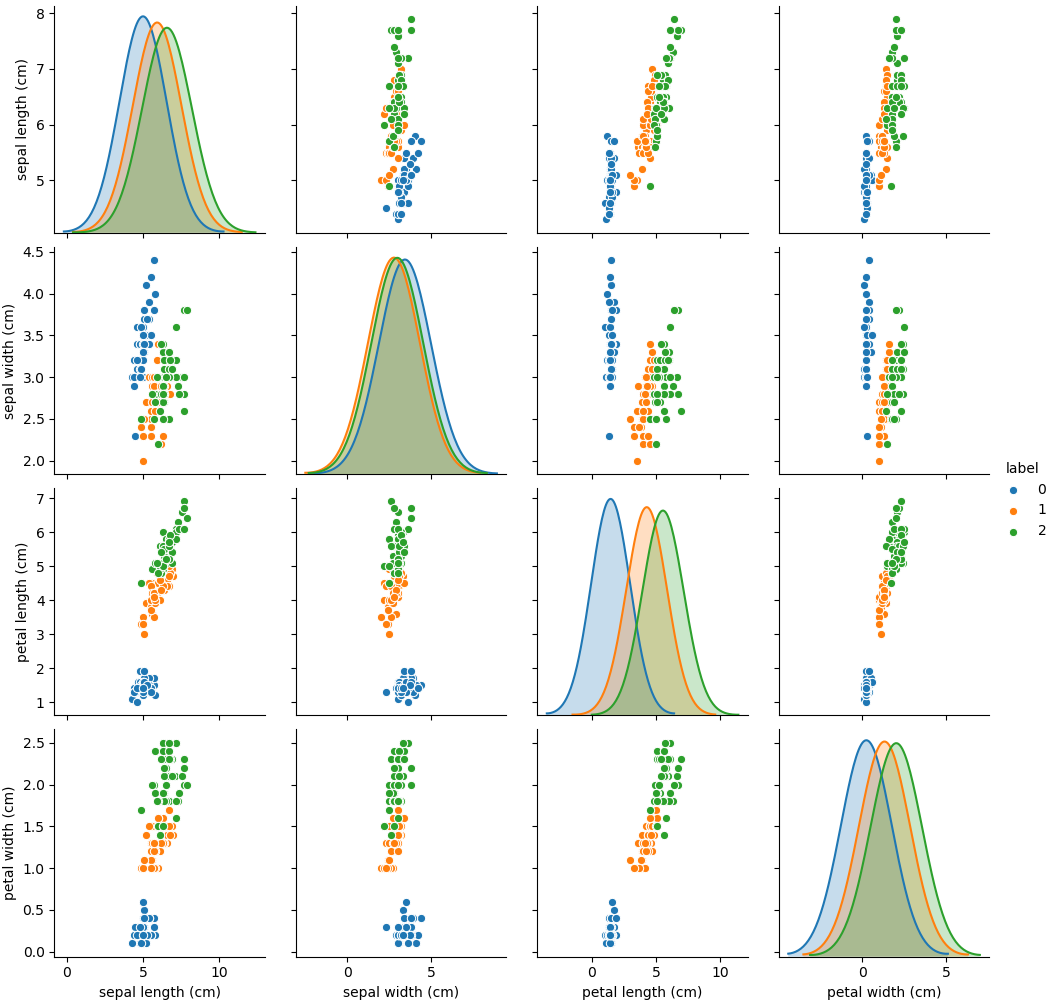

In [18]:
from IPython.display import display, HTML

# Display the `histograms` artifact
display(HTML('<h3>Histograms</h3>'), HTML(describe_run.outputs['histograms']))


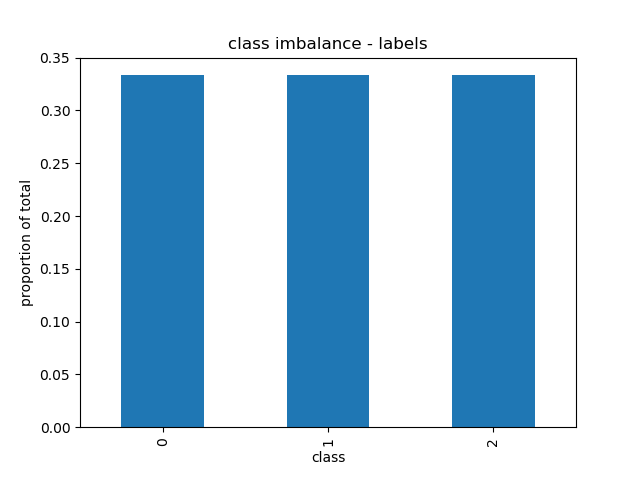

In [19]:
# Display the `imbalance` artifact
display(HTML('<h3>Imbalance<h3>'),
        HTML(filename=describe_run.outputs['imbalance']))


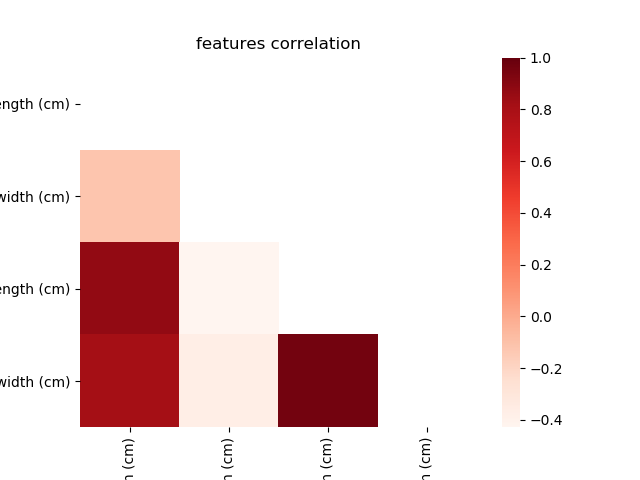

In [20]:
# Display the `correlation` artifact
display(HTML('<h3>Correlation Matrix<h3>'),
        HTML(filename=describe_run.outputs['correlation']))

## Step 4: Run Model Training at Scale <a id="gs-step-run-model-training"></a>


It's time to train your model.
Start by adding a training project function that uses the [`sklearn_classifier` MLRun marketplace function](https://github.com/mlrun/functions/tree/master/sklearn_classifier) to train three scikit-learn models; (you can use this function to train any scikit-learn model).
Then, use an MLRun task to run your function in order to train and evaluate the models and select the optimal model.

#### Add a Training Function <a id="gs-train-model-add-func"></a>


Run the following code to add to your project a `train` function that uses the `sklearn_classifier` marketplace function code, and create a related `train` function object.

In [21]:
project.set_function('hub://sklearn_classifier', 'train')
train = project.func('train').apply(mount_v3io())

#### Run a Model-Training Task <a id="gs-train-model-run-task"></a>


The following code uses the MLRun `NewTask` method to create a new `train` MLRun task and a related `train_task` task object for executing the `train` project function.
An MLRun **task** defines the parameters, inputs, and outputs of a logical job or task to execute.
The advantage of tasks is that they're independent of the runtime environment.
Hence, you can define a task once and use it in different scenarios.

The `NewTask` `inputs` parameter is set to the `iris_dataset` data set, as stored in the output artifacts of the previously executed `get_data` job.
The `test_size` training parameter (`params.test_size`) is set to 0.10.
This means that the `iris_dataset` data set will make up 90% of the training data set, and the remaining 10% will be the scikit-learn test data set.

The `train_task` task (and therefore the `train` function) is executed by using the `run` method.
The returned run object is stored in a `train_run` variable.

The code uses the `with_hyper_params` task method, which enables running multiple iterations of the same task with different parameter combinations, comparing the results, and selecting the optimal combination based on the specified selection criteria.
In this example, there's a single `models` parameter with different values (model names) so as to compare multiple models; the model with the most accurate training results is selected as the optimal model.
The `with_hyper_params` method receives the following parameters

- **`hyperparams`** &mdash; a dictionary of parameter names and parameter-values lists.
  The example defines a single hyperparameter named `model_pkg_class`, and sets its value to a `models` variable that contains a list of three scikit-learn models to train and evaluate. 
- **`selector`** &mdash; a string of the format `'<min/max>.<validation criterion>'`, which defines a selection criterion for selecting the winning run iteration.
  For example, `"max.accuracy"` selects the iteration with the most accurate results while `"min.loss"` selects the iteration with minimum loss.
  The example uses the `max.accuracy` selector to select the model with the most accurate training results.

In [22]:
# Configure the models to train
models = ["sklearn.ensemble.RandomForestClassifier", 
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

In [23]:
# Create a training task
train_task = NewTask(name="train",
                     params={"sample": -1,
                             "label_column": "label",
                             "test_size": 0.10},
                     inputs={"dataset": get_data_run.outputs['iris_dataset']})

# Run the training task
train_run = train.run(train_task.with_hyper_params({'model_pkg_class': models},
                                                   selector='max.accuracy'),
                      artifact_path=artifact_path)

[mlrun] 2020-06-25 13:32:16,891 starting run train uid=0b9eb0c08f0e42038a8f0e352e445dd8  -> http://mlrun-api:8080
[mlrun] 2020-06-25 13:32:17,350 Job is running in the background, pod: train-f86j2
[mlrun] 2020-06-25 13:32:25,923 best iteration=1, used criteria max.accuracy
[mlrun] 2020-06-25 13:32:26,587 run executed, status=completed
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iris-iguazio,...2e445dd8,0,Jun 25 13:32:21,completed,train,v3io_user=iguaziokind=jobowner=iguazio,dataset,sample=-1label_column=labeltest_size=0.1,best_iteration=1accuracy=0.9705882352941176test-error=0.029411764705882353auc-micro=0.9961072664359862auc-weighted=0.9949732620320856f1-score=0.9679633867276888precision_score=0.9666666666666667recall_score=0.9722222222222222,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run 0b9eb0c08f0e42038a8f0e352e445dd8 --project getting-started-iris-iguazio , !mlrun logs 0b9eb0c08f0e42038a8f0e352e445dd8 --project getting-started-iris-iguazio
[mlrun] 2020-06-25 13:32:29,770 run executed, status=completed


### Review the Run Output <a id="gs-train-model-run-output-review"></a>


As with the previous executions, you can view extensive run information and artifacts from Jupyter Notebook and the MLRun dashboard, as well as browse the task artifacts from the platform dashboard.
See the output-review information in the previous steps.

Your project's artifacts directory (**/User/getting-started-tutorial/jobs**) contains an **iteration_results.csv** output artifact with the results for the training-task run iterations, and **&lt;iteration number&gt;** subdirectories with the artifacts for all the run iterations (i.e., for each evaluated model).<br>
The **plots** subdirectory has HTML output artifacts for the selected run iteration; (the **tests** subdirectory contains the artifacts for the test data set).

Use the following code to extract and display information from the run object &mdash; the name of the selected trained model, the best accuracy that was achieved with this model, and the `confusion` and `roc` HTML output artifacts for the optimal run iteration.


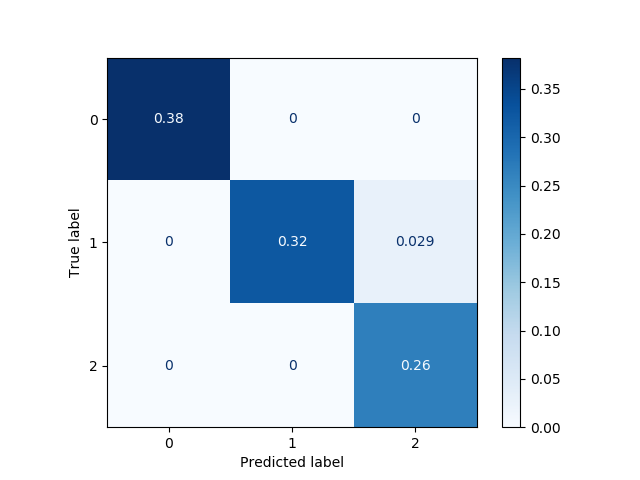


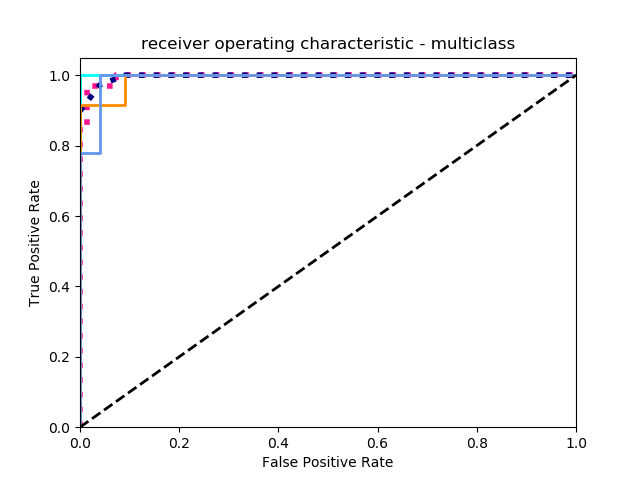

In [24]:
# Display the name of the selected model
display(HTML(f'<b>Best model:</b> '
             f'{models[train_run.outputs["best_iteration"]]}'))

# Display the accuracy for the optimal run iteration
display(HTML(f'<b>Accuracy:</b> {train_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML('<h3>Confusion Matrix:</h3>'),
        HTML(filename=train_run.outputs['confusion-matrix']))
display(HTML('<h3>ROC Curve:</h3>'), HTML(filename=train_run.outputs['roc-multiclass']))

## Step 5: Test Your Model <a id="gs-step-test-model"></a>


Now that you have a trained model, you can test it: run a task that uses the [`test_classifier` marketplace function](https://github.com/mlrun/functions/tree/master/test_classifier) to run the selected trained model against the test data set, as returned for the training task (`train`) in the previous step.

#### Add a Test Function <a id="gs-test-model-add-func"></a>


Run the following code to add to your project a `test` function that uses the `test_classifier` marketplace function code, and create a related `test` function object.

In [25]:
project.set_function('hub://test_classifier', 'test')
test = project.func('test').apply(mount_v3io())

#### Run a Model-Testing Task <a id="gs-test-model-run-task"></a>


Use a task to run the model-testing function:

- Create a new `test` task and a related `test_task` task object for executing the `test` project function, which runs the `test_classifier` marketplace function.<br>
  In the `NewTask` call, configure parameters for the test function (`params`), and provide the selected trained model from the `train` task as an input artifact (`inputs`).
- Run the task by using the `run` MLRun method, and assign the returned run object to a `test_run` variable.

In [26]:
test_task = NewTask(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path": train_run.outputs['model'],
                            "test_set": train_run.outputs['test_set']}
                    )
test_run = test.run(test_task,
                    artifact_path=artifact_path)

[mlrun] 2020-06-25 13:32:29,949 starting run test uid=25e74f5c71ca4aa283bebd35e85c223f  -> http://mlrun-api:8080
[mlrun] 2020-06-25 13:32:30,412 Job is running in the background, pod: test-4phtp
[mlrun] 2020-06-25 13:32:36,862 run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iris-iguazio,...e85c223f,0,Jun 25 13:32:35,completed,test,v3io_user=iguaziokind=jobowner=iguaziohost=test-4phtp,models_pathtest_set,label_column=labelplots_dest=plots/test,accuracy=0.9333333333333333test-error=0.06666666666666667auc-micro=0.9633333333333334auc-weighted=0.9888888888888889f1-score=0.9137254901960784precision_score=0.8888888888888888recall_score=0.9629629629629629,confusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 25e74f5c71ca4aa283bebd35e85c223f --project getting-started-iris-iguazio , !mlrun logs 25e74f5c71ca4aa283bebd35e85c223f --project getting-started-iris-iguazio
[mlrun] 2020-06-25 13:32:39,770 run executed, status=completed


### Review the Run Output <a id="gs-test-model-run-output-review"></a>


Check the output information for your run in Jupyter Notebook and on the MLRun dashboard.

Use the following code to display information from the run object &mdash; the accuracy of the model, and the `confusion` and `roc` HTML output artifacts.


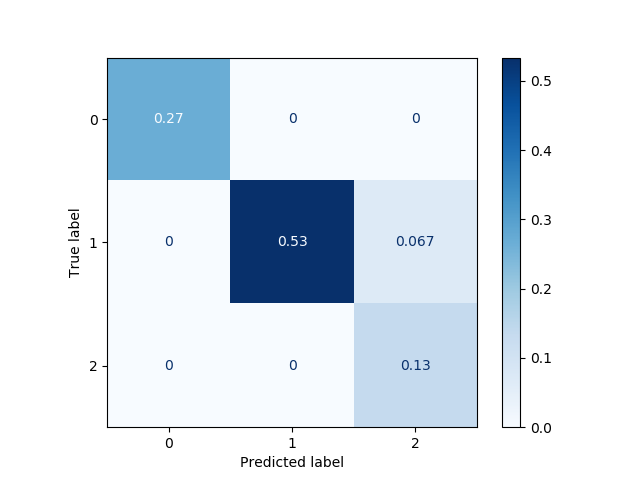


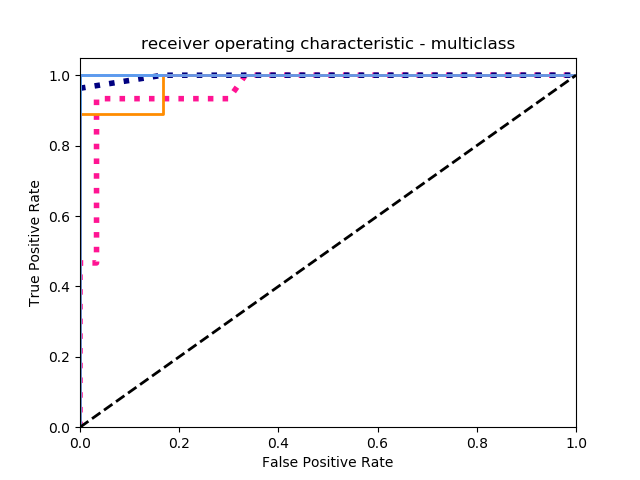

In [27]:
# Display the model accuracy
display(HTML(f'<b>Test Accuracy:</b> {test_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML("<h3>Confusion matrix:</h3>"),
        HTML(filename=test_run.outputs['confusion-matrix']))
display(HTML("<h3>ROC Curve:</h3>"), HTML(filename=test_run.outputs['roc-multiclass']))

## Step 6: Create and Run a Fully Automated ML Pipeline <a id="gs-step-create-n-run-ml-pipeline"></a>


You're now ready to create a full ML pipeline.
This is done by using [Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/overview/pipelines-overview/), which is integrated into the Iguazio Data Science Platform.
Kubeflow Pipelines is an open-source framework for building and deploying portable, scalable machine-learning workflows based on Docker containers.
MLRun leverages this framework to take your existing code and deploy it as steps in the pipeline.

### Add Serving Functions from the MLRun Functions Marketplace <a id="gs-ml-pipeline-add-functions"></a>


Add to your project a real-time model-server function (`serving`) and a REST model API tester function (`serving-tester`), which run the [`model_server`](https://github.com/mlrun/functions/tree/master/model_server) and [`model_server_tester`](https://github.com/mlrun/functions/tree/master/model_server_tester) MLRun marketplace functions, respectively.

In [28]:
project.set_function('hub://model_server', 'serving')
project.set_function('hub://model_server_tester', 'serving-tester')

### Define and Save a Pipeline Workflow <a id="gs-pipeline-workflow-define-n-save"></a>


A pipeline is created by running an MLRun **"workflow"**.
The following code defines a workflow and writes it to a file in your project directory (**/User/getting-started-tutorial/jobs/workflow.py**).
The workflow describes a directed acyclic graph (DAG) for execution using Kubeflow Pipelines, and depicts the connections between the functions and the data as part of an end-to-end pipeline.
The workflow file has two parts &mdash; initialization of the function objects, and definition of a pipeline DSL (domain-specific language) for connecting the function inputs and outputs.
Examine the code to see how functions objects are initialized and used (by name) within the workflow.

The defined pipeline includes the following steps:

- Ingest the Iris flower data set (`ingest`).
- Analyze the data set (`describe`).
- Train and test the model with hyperparameters (`train`).
- Deploy the model as a real-time serverless function (`deploy`).
- Test the serverless serving-model function with a test data set by using REST API calls (`Tester`).

> **Note**: A pipeline can also include continuous build integration and deployment (CI/CD) steps, such as building container images and deploying models.

In [29]:
%%writefile {path.join(project_path, 'workflow.py')}

from kfp import dsl
from mlrun import mount_v3io

funcs = {}
DATASET = 'iris_dataset'
LABELS = "label"
MODELS = ["sklearn.ensemble.RandomForestClassifier",
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]


# Configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    for f in functions.values():
        f.apply(mount_v3io())

    functions['serving'].metadata.name = 'getting-started-serving'


# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(
    name="Getting-started tutorial",
    description="This tutorial is designed to demonstrate some of the main "
                "capabilities of the Iguazio Data Science Platform.\n"
                "The tutorial uses the Iris flower data set."
)
def kfpipeline(source_url='http://iguazio-sample-data.s3.amazonaws.com/iris_dataset.csv'):

    # Ingest the data set
    ingest = funcs['get-data'].as_step(
        name="get-data",
        handler='get_data',
        inputs={'source_url': source_url},
        params={'format': 'pq'},
        outputs=[DATASET])

    # Analyze the dataset
    describe = funcs["describe"].as_step(
        name="summary",
        params={"label_column": LABELS},
        inputs={"table": ingest.outputs[DATASET]})

    # Train a model with hyperparemeters
    train = funcs["train"].as_step(
        name="train",
        params={"sample": -1,
                "label_column": LABELS,
                "test_size": 0.10},
        hyperparams={'model_pkg_class': MODELS},
        selector='max.accuracy',
        inputs={"dataset": ingest.outputs[DATASET]},
        outputs=['model', 'test_set'])

    # Test and visualize the model
    test = funcs["test"].as_step(
        name="test",
        params={"label_column": LABELS},
        inputs={"models_path": train.outputs['model'],
                "test_set": train.outputs['test_set']})

    # Deploy the model as a serverless function
    deploy = funcs["serving"].deploy_step(
        models={f"{DATASET}_v1": train.outputs['model']})

    # Test the new model server (via REST API calls)
    tester = funcs["serving-tester"].as_step(
        name='serving-tester',
        params={'addr': deploy.outputs['endpoint'], 'model': f"{DATASET}_v1"},
        inputs={'table': train.outputs['test_set']})

Writing /User/getting-started-tutorial/conf/workflow.py


#### Register the Workflow <a id="gs-register-workflow"></a>


Use the `set_workflow` MLRun project method to register your workflow with MLRun.
The following code sets the `name` parameter to the selected workflow name ("main") and the `code` parameter to the name of the workflow file that is found in your project directory (**workflow.py**).

In [30]:
# Register the workflow file as "main"
project.set_workflow('main', 'workflow.py')

### Save Your Project Configuration <a id="gs-save-project"></a>


Use the `save` MLRun project method to save your project definitions to a project-configuration file in your project directory (**/User/getting-started-tutorial/conf**).
The default name of the project file is **project.yaml**, but you can optionally change it by setting the `filepath` parameter of the `save` method.

> **Note:** It's recommended that you commit your project-configuration file and any future changes to this file to a Git repository.

In [31]:
project.save()

<a id='gs-pipeline-workflow-run'></a>
### Run Your Pipeline Workflow

Use the `run` MLRun project method to execute your workflow pipeline with Kubeflow Pipelines.
The tutorial code sets the following method parameters; (for the full parameters list, see the MLRun documentation or embedded help):

- **`name`** &mdash; the workflow name (in this case, "main" &mdash; see the previous step).
- **`arguments`** &mdash; A dictionary of Kubeflow Pipelines arguments (parameters).
  The tutorial code sets this parameter to an empty arguments list (`{}`), but you can edit the code to add arguments.
- **`artifact_path`** &mdash; a path or URL that identifies a location for storing the workflow artifacts.
  You can use `{{workflow.uid}}` in the path to signify the ID of the current workflow run iteration.
  The tutorial code sets the artifacts path to a **&lt;worker ID&gt;** directory (`{{workflow.uid}}`) in a **pipeline** directory within the current tutorial directory (**/User/getting-started-tutorial/pipeline/&lt;worker ID&gt;**).
- **`dirty`** &mdash; set to `True` to allow running the workflow also when the project's Git repository is dirty (i.e., contains uncommitted changes).
  (When the notebook that contains the execution code is in the same Git directory as the executed workflow, the directory will always be dirty during the execution.)

The `run` method returns the ID of the executed workflow, which the code stores in a `run_id` variable.
You can use this ID to track the progress or your workflow, as demonstrated in the following sections.

> **Note**: You can also run the workflow from a command-line shell by using the `mlrun` CLI.
> The following CLI command defines a similar execution logic as that of the `run` call in the tutorial:
> ```
> mlrun project /User/getting-started-tutorial/conf -r main -p "$V3IO_HOME_URL/getting-started-tutorial/pipeline/{{workflow.uid}}/"
> ```

In [32]:
run_id = project.run(
    'main',
    arguments={}, 
    artifact_path=path.abspath(path.join('pipeline','{{workflow.uid}}')), 
    dirty=True)

[mlrun] 2020-06-25 13:32:40,454 using in-cluster config.


[mlrun] 2020-06-25 13:32:41,432 Pipeline run id=ef63afaf-542c-4747-a63f-e18471650e43, check UI or DB for progress


### Review the Run Output <a id="gs-pipeline-workflow-run-output-review"></a>


The run output contains hyperlinks to the relevant sections for your workflow in the platform dashboard's pipelines dashboard (**Pipelines**):

Select the **Experiments link** to view information about the executed experiments.
<br><br>
![getting_started-pipeline](./assets/getting_started-pipeline-experiment.png)

Select the **Run link** to view the pipeline execution.
The following image illustrates the execution graph for a completed run:
<br><br>
![getting_started-pipeline](./assets/getting_started-pipeline.png)

### Track the Pipeline Workflow Execution <a id="gs-pipeline-workflow-track-execution"></a>


You can use the following code to view the information for your pipeline workflow execution &mdash; including inputs and outputs, run results, and artifacts.

The code uses the `get_run_db` MLRun method to get an MLRun DB object for your project's MLRun database/API service ("the MLRun DB"), and the `connect` method to connect to the DB.
The returned database object is stored in a `db` variable, which can then be used to run additional methods for performing different operations on the database.

The code uses the `list_runs` method to list all runs for the current workflow.
The workflow is referenced by using the workflow ID that was returned for the workflow execution and saved to the `run_id` variable.

In [33]:
from mlrun import get_run_db
db = get_run_db().connect()
db.list_runs(project=project.name, labels=f'workflow={run_id}').show()

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-iris-iguazio,...92652de9,0,Jun 25 13:33:40,completed,serving-tester,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=jobhost=serving-tester-7qrdk,table,addr=http://54.209.189.220:31002model=iris_dataset_v1,total_tests=15errors=0match=14avg_latency=16255min_latency=13736max_latency=30032,latency
getting-started-iris-iguazio,...80b35ad2,0,Jun 25 13:33:25,completed,test,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=jobhost=test-mt7gx,models_pathtest_set,label_column=label,accuracy=0.9333333333333333test-error=0.06666666666666667auc-micro=0.9666666666666668auc-weighted=0.9888888888888889f1-score=0.9137254901960784precision_score=0.8888888888888888recall_score=0.9629629629629629,confusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclasstest_set_preds
getting-started-iris-iguazio,...22843bcb,0,Jun 25 13:33:04,completed,summary,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=jobhost=summary-qbr87,table,label_column=label,,histogramsimbalanceimbalance-weights-veccorrelation-matrixcorrelation
getting-started-iris-iguazio,...424db634,0,Jun 25 13:33:03,completed,train,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=job,dataset,sample=-1label_column=labeltest_size=0.1,best_iteration=1accuracy=0.9705882352941176test-error=0.029411764705882353auc-micro=0.9969723183391004auc-weighted=0.9949732620320856f1-score=0.9679633867276888precision_score=0.9666666666666667recall_score=0.9722222222222222,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodeliteration_results
getting-started-iris-iguazio,...e3e90146,0,Jun 25 13:32:49,completed,get-data,v3io_user=iguazioowner=iguazioworkflow=ef63afaf-542c-4747-a63f-e18471650e43kind=jobhost=get-data-9pl5w,source_url,format=pq,,iris_dataset


### Serve Your Model <a id="gs-serve-model"></a>


You can now run the pipeline's model-serving function &mdash; `getting-started-serving` (which is the metadata name that you gave the project's [`serving` function](#gs-ml-pipeline-add-functions) in the [workflow definition](#gs-pipeline-workflow-define-n-save)): append `iris_dataset_v1/predict` to the function's URL to create the `POST` URL; change the body type to `JSON`; and add the following text to the request body:
```json
{"instances": [[5.1, 3.5, 1.4, 0.2]]}
```
You can perform these steps from the platform dashboard: select **Projects** from the side navigation menu, select your project ("getting-started-iris"), and then select the `getting-stated=serving` function and execute the required steps, as demonstrated in the following dashboard flow:
<br><br>
![getting_started-pipeline](./assets/getting_started-model_serving_test.gif)

## Done! <a id="gs-done"></a>


Congratulation. You've completed your first Iguazio Data Science Platform tutorial!.<br>
To learn more, go to the **demos** tutorial-notebooks directory and check out the provided end-to-end use-case demo applications.

[Back to top](#top)